# Basics of MPI-parallel NGSolve



In [ ]:
num_procs = '20'

In [ ]:
from usrmeeting_jupyterstuff import *

In [ ]:
stop_cluster()

In [ ]:
start_cluster(num_procs)
connect_cluster()

## Using MPI through NGSolve
For convenience, NGSolve provides access to a little bit of MPI-functionality through the python interface.

However, the general philosophy is that NGSolve should handle MPI-stuff on C++ side and not require the user
to directly use it.

In cases where more MPI functionality is needed, mpi4py can be used.



## Getting Started
MPI_Init returns a wrapper around the MPI-communcator used in NGSolve.

It provides some basic functionality, for example it can tell us the number of
procs in it, and give us the rank of each one:

In [ ]:
%%px
from ngsolve import *
comm = MPI_Init()
print("Hello from rank ", comm.rank, ' of ', comm.size)

 
 
Additionally, "comm" provides:
- time measurement
- barriers
- computing sums, minima, maxima

In [ ]:
%%px
t = comm.WTime()
s2 = comm.Sum(1)
t = comm.Max(comm.WTime()-t)
if comm.rank==0:
    print('There are ', s2, ' of us, which took us ', round(t,6), 'seconds to figure out')

## Distributed Meshes
When we load a mesh from a file in parallel, it gets distributed among the ranks and each one gets only a part of it, 
**rank 0 gets nothing**.


In [ ]:
%%px
mesh = Mesh('square.vol')
print('rank', str(comm.rank)+"'s part of the mesh has ", mesh.ne, 'elements, ', \
      mesh.nface, 'faces, ', mesh.nedge, 'edges and ', mesh.nv, ' vertices')

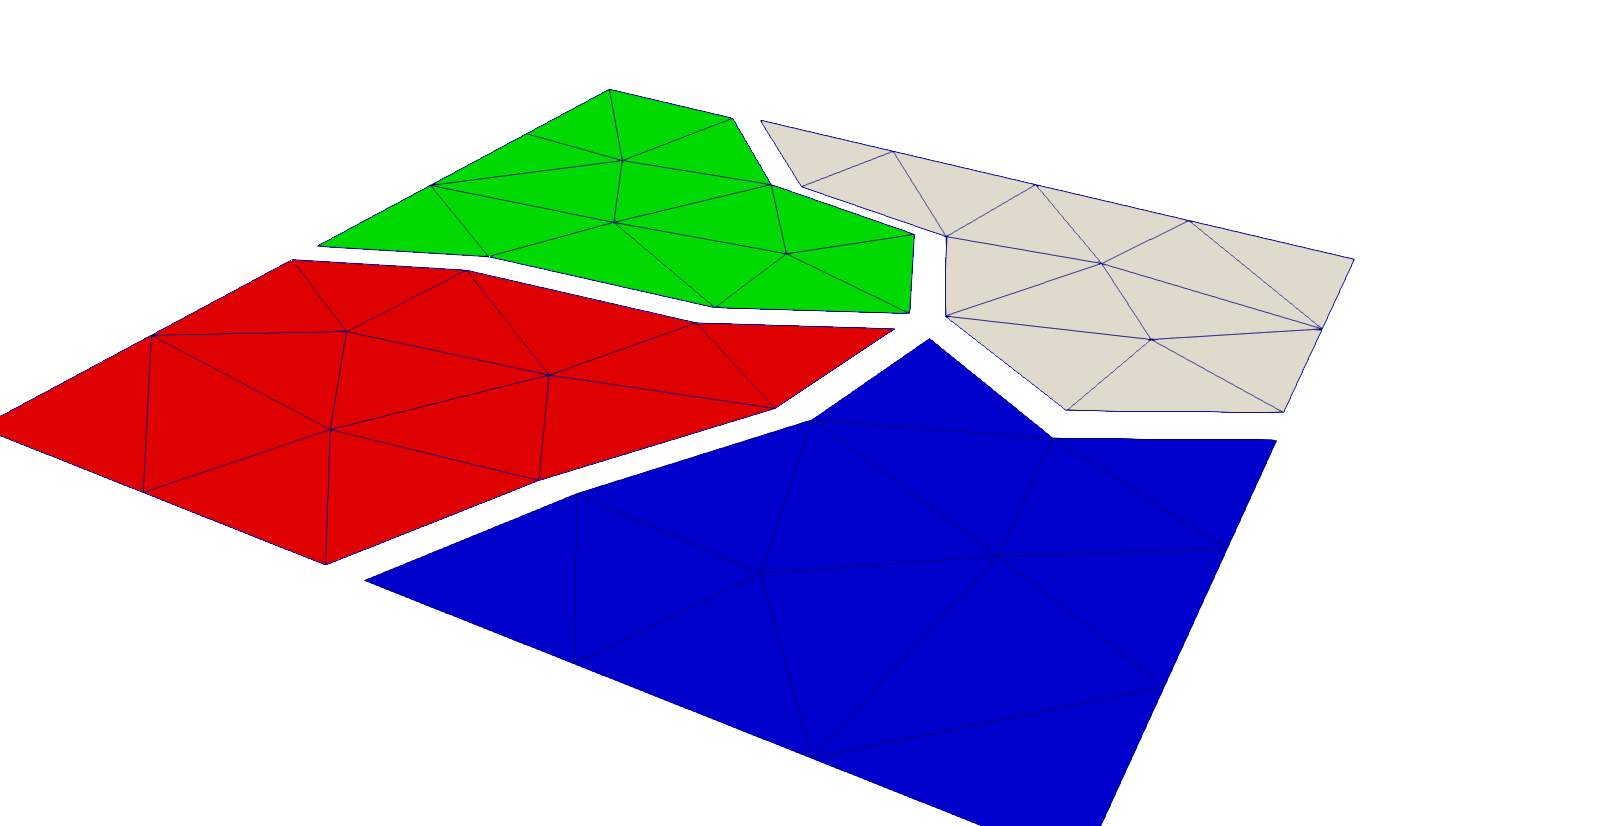

However, the entire geometry information is present everywhere:

In [ ]:
%%px --targets 0:5
print('rank', comm.rank, 'Materials:', mesh.GetMaterials())
print('rank', comm.rank, 'Boundaries: ', mesh.GetBoundaries())

## Distributed Finite Element Spaces
When we define a Finite Element Space on a distributed mesh, each rank constructs a
Finite Element Space on it's part of the mesh.

In [ ]:
%%px
fes = H1(mesh, order=3, dirichlet='bottom|left')
print('fes on rank', comm.rank, 'has', fes.ndof, 'DOFs, globally we have ', fes.ndofglobal)

In [ ]:
%%px
nd2 = comm.Sum(fes.ndof)
if comm.rank==0:
    print('Strangely, the sum of all local DOFs is ', nd2, '!=', fes.ndofglobal)

If we just sum up the dimensions of the local spaces $V^i$, we get the dimension of 
$ \Pi_i V^i$ and not the dimension of 

$$
V = \Pi_i V^i \cap C^0(\Omega)
$$

Some base functions have to be shared across subdomains. Each subdomain takes the place of a makro Finite Element.
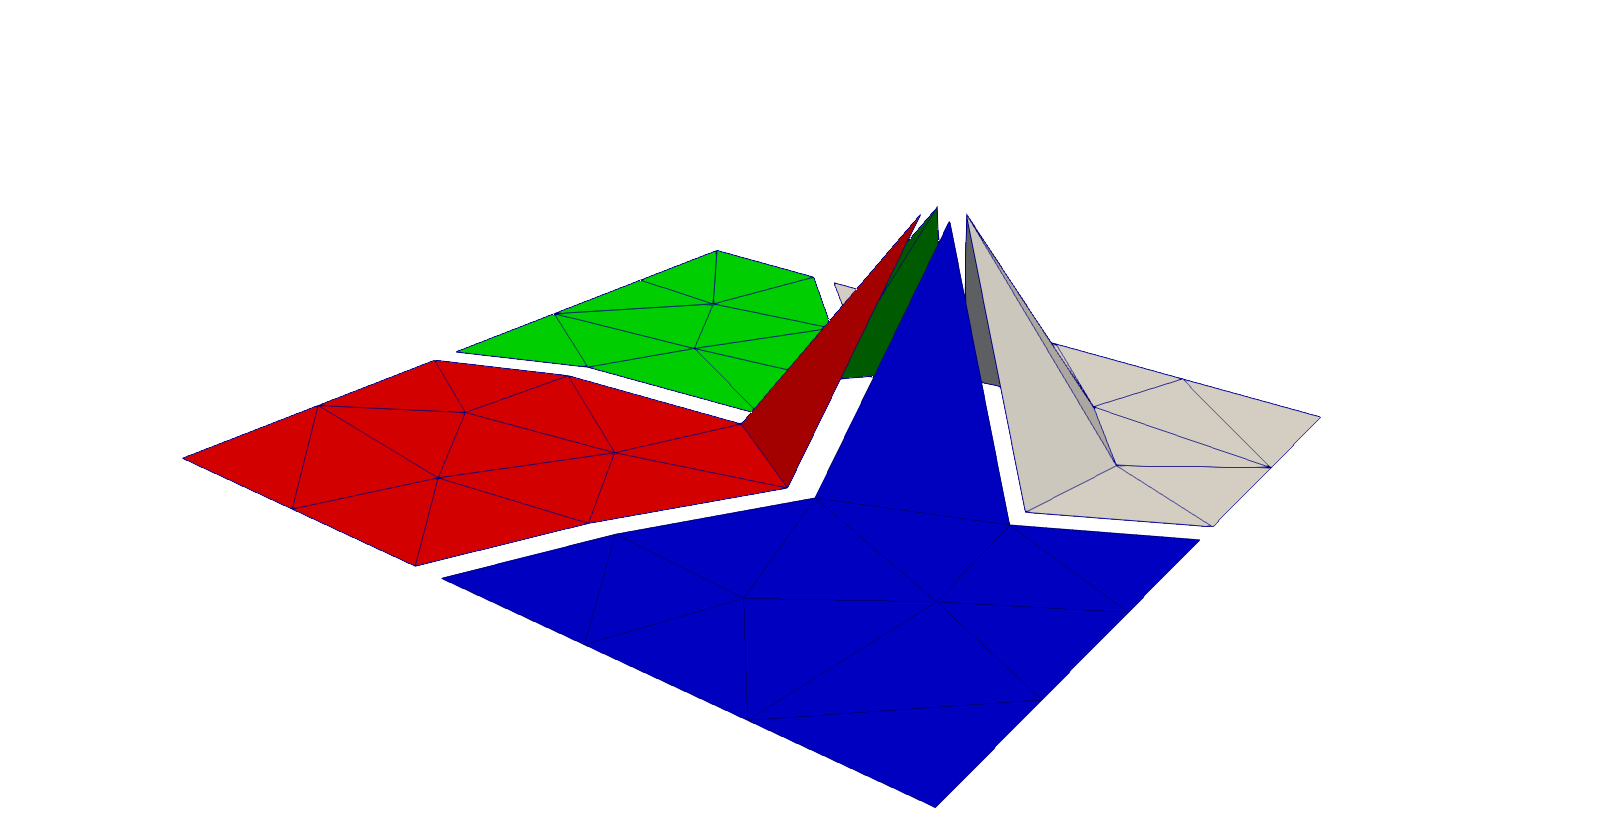


Information about how the DOFs stick together on a global level are stored in 
the "ParallelDofs" object:

In [ ]:
%%px
pd = fes.ParallelDofs()
print('rank', comm.rank, 'has', pd.ndoflocal, 'local DOFs, globally we have', pd.ndofglobal)

We can find out which DOFs are shared with which ranks.

In [ ]:
%%px --target=3
print('I am rank ', comm.rank)
print('---')

for k in range(min(10,fes.ndof)):
    print('I share DOF', k, 'with ranks:', [p for p in pd.Dof2Proc(k)])
    
print('... and so forth ...')
print('\n')

for p in range(0, comm.size-1):
    if len(pd.Proc2Dof(p)):
        print('DOFs I share with rank', p, ': ', [p for p in pd.Proc2Dof(p)])

There are a couple of points to consider here:
 - Locally, DOFs are numbered 0..ndoflocal-1.
 - There is no global enumeration!
 - The local numbering of DOFs is conistent across subdomain boundaries.
   (This just means that there exists some global enumeration of DOFs that is cinsistent with the local ones.)

## Distributed Weak Formulations & Linear Algebra

Linear- or Bilinearforms can be split into subdomain contributions.

For example, the usual bilinear form $a(\cdot, \cdot)$ associated to Poisson's equation can be split into
$a_i(\cdot, \cdot)$ defined by:
$$
a(u,v) = \sum_i a_i(u, v) = \sum_i \int_{\Omega_i} \nabla u \nabla v~dx = \sum_i a(u_{|\Omega_i}, v_{|\Omega_i})
$$

When we write down BLFs and LFs for distributed FESpace, we actually simply write down
it's local contributions. 

The FESpace figures out how to stick them together to form global forms. 


In [ ]:
%%px
u,v = fes.TnT()
a = BilinearForm(fes)
a += SymbolicBFI(grad(u)*grad(v))
a.Assemble()

Let us see what we get after assembling the bilinear form:

In [ ]:
%%px --target=1
print('a.mat is a', type(a.mat))

## Parallel Matrices and Vectors

The general principle for distributed linear algebra objects is:

*Parallel Object = Local Object + ParallelDofs*

$ $

### Matrices

In [ ]:
%%px --target=1,2
print('a.mat.local_mat on rank', comm.rank, 'is a', type(a.mat.local_mat), 'of dimensions', a.mat.local_mat.height, a.mat.local_mat.width)
print('lcoal fes ndof: ', fes.ndof)
print('a.mat.row_pardofs: ', a.mat.row_pardofs)
print('a.mat.col_pardofs: ', a.mat.col_pardofs)
print('fes pardofs:       ', fes.ParallelDofs())

Each rank assembles it's local contribution to the global bilinear form into a sparse matrix, with dimensions matching that of the *local* FESpace!

Let us assume we have some global numbering, and assume that $I_k$ is the set of indices corresponding to DOFs
on rank $k$. 

The ebmedding matrices $E_k\in\mathbb{R}^{n_i\times n}$ take local vectors of dimension $n_k$ and gives us global vectors of dimension $n$ .

The global matrix $A$, operating on vectors of dimension $n$, can be assembled from the local matrices in the same way
we usually assemble our FEM matrices from element matrices:

$$
A = \sum_i E_i A^{(i)} E_i^T
$$

Importantly, the local matrices are **not** simply diagonal blocks of the global matrix,  $A^i$ only has partial values for DOFs that are shared with another rank, $A^{(i)} \neq E_i^T A E_i$.

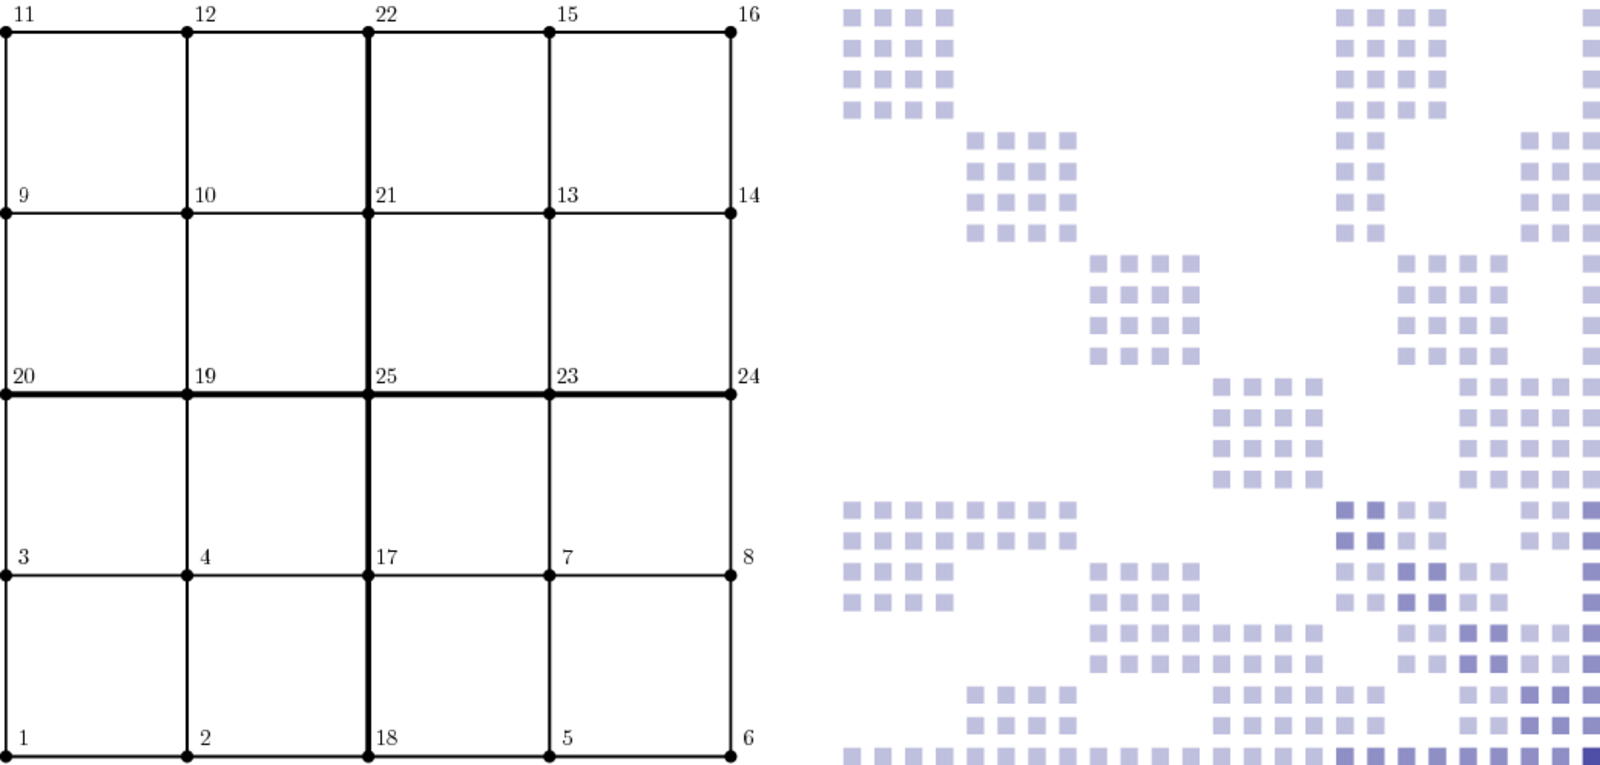


#### Note
**We never globally assemble $A$!!**

A common approach used by other software packages is to actually assemble $A$ and distribute it by rows.

$ $

### Vectors

Things look very similar for parallel vectors, they are again implemented as short, local vectors that
make up the global one:


In [ ]:
%%px 
f = LinearForm(fes)
f += SymbolicLFI(x*y*v)
f.Assemble()
gfu = GridFunction(fes)

In [ ]:
%%px --target 1
print('length of vector:    ', len(gfu.vec))
print('length of local vec: ', len(gfu.vec.local_vec))
print('dim local fes:       ', fes.ndof)
print('dim global fes:      ', fes.ndofglobal)

Parallel Vectors additionally have a "ParallelStatus", which can be:
- **Cumulated**, whenhe local vectors $v^i$ are just restrictions of the global vector $v$:
$$
v^{(i)} = E_i^T v
$$
- **Distributed**, when, similarly to parallel matrices, the global vector is the sum of local contributions
$$
v = \sum_i E_iv^{(i)}
$$

$ $


The vector of the linear form $f$ is a collection of locally assembled vectors, so it is distributed.

The vector of the GridFunction gfu has been initialized with zeros, so it has consistent values, it is cumulated.

In [ ]:
%%px --target 1
print('status f vec:         ', f.vec.GetParallelStatus())
print('status vec.local_vec: ', f.vec.local_vec.GetParallelStatus())
print('')
print('status gfu vec:       ', gfu.vec.GetParallelStatus())
print('status vec.local_vec: ', gfu.vec.local_vec.GetParallelStatus())

*Multiplication of a parallel matrix with a cumulated vector gives a distributed one:*

$$
w = A v = (\sum_i E_i A^{(i)} E_i^T) v = \sum_i E_i A^{(i)} E_i^Tv = \sum_i E_i A^{(i)}v^{(i)} = \sum_i E_i w^{(i)}
$$


In [ ]:
%%px
v = gfu.vec.CreateVector()
w = gfu.vec.CreateVector()
v[:] = 1.0
w.data = a.mat * v

In [ ]:
%%px --target 1
print('status v: ', v.GetParallelStatus())
print('status w: ', w.GetParallelStatus())

## Solvers and Preconditioners with MPI

Not all solvers and preconditioners included in NGSolve also work with MPI, but many do:
### Direct Solvers
- masterinverse: Collect the entire matrix on the "master" and invert sequentially there.
- MUMPS inverse: Distributed parallel inverse, scalability is limited.

### Preconditioners
- BDDC
- 'hypre': Boomer AMG
- 'hypre_ams': Auxiliary Maxwell Space AMG 
- 'local'


In [ ]:
%%px
c = Preconditioner(a, 'hypre')
#c = Preconditioner(a, 'bddc', inverse='mumps')
a.Assemble()

In [ ]:
%%px
gfu.vec.data = solvers.CG(mat=a.mat, pre=c.mat, rhs=f.vec, tol=1e-6, maxsteps=30, printrates=comm.rank==0)

In [ ]:
stop_cluster()